<a href="https://colab.research.google.com/github/lzumta/Reinforcement-Learning-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

In [ ]:
# Import 

import torch
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from decimal import Decimal
from tensorflow import keras
from tensorflow.keras import layers
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import time


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [ ]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [ ]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    #np.random.seed(42)
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('-----------------')
    print(X)
    #print(allowed_a)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 2]
 [0 3 0 0]]
check?  0
dofk2  1

[[0 0 0 0]
 [0 1 0 2]
 [0 0 0 0]
 [3 0 0 0]]
0  0
-----------------
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
check?  0
dofk2  0

[[0 0 0 0]
 [0 1 0 0]
 [0 0 2 0]
 [3 0 0 0]]
-1  1
-----------------
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
check?  0
dofk2  0


In [ ]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 
np.random.seed(42)
S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

rewards = []
moves = []

for n in range(N_episodes):

    if n % 500 == 0:
      print('Average reward:',np.mean(rewards[n-500:n]),'Number of steps: ',np.mean(moves[n-500:n]))
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE

    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)
            rewards.append(R)
            moves.append(i)
            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average reward: nan Number of steps:  nan
Average reward: -0.588 Number of steps:  7.29
Random_Agent, Average reward: -0.628 Number of steps:  7.151


In [ ]:
# moving average
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
#print(moving_average(R_save, n=500))

NameError: ignored

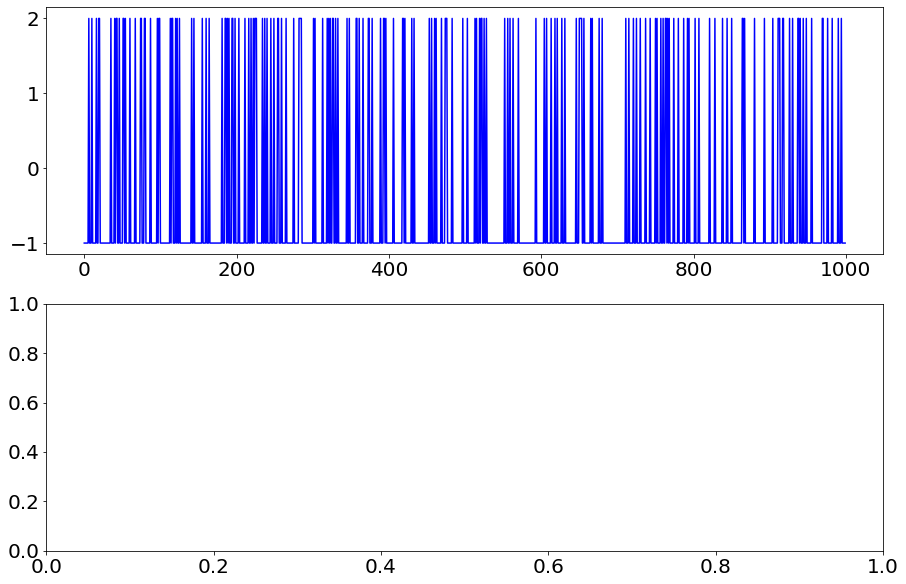

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(2,figsize=(15,10))

axs[0].plot(np.arange(0,N_episodes), R_save_random, 'b')
axs[1].plot(np.arange(0,N_episodes-1999), moving_average(R_save_random, n=2000), 'r')
axs[0].set_title("Reward per game")
axs[1].set_title("Exponential moving average")
plt.xticks([])

Text(0, 0.5, 'Number of moves')

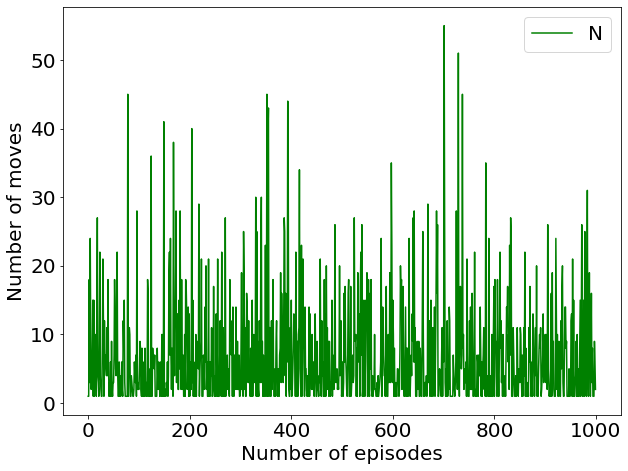

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,7.5)

plt.plot(np.arange(0,N_episodes),N_moves_save_random,'g')
plt.legend('Number of moves')
plt.xlabel('Number of episodes')
plt.ylabel('Number of moves')

In [ ]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

memory_size = 2000

## INITALISE YOUR NEURAL NETWORK...
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_in, N_h)
        self.out = nn.Linear(N_h, N_a)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        action = self.out(x)
        return action



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

In [ ]:
class ChessAgent():
    def __init__(self):
        super(ChessAgent, self).__init__()
        self.policy_net = Net()
        self.target_net = Net()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((memory_size, N_in * 2 + 2))
        
        self.optimizer = torch.optim.SGD(self.policy_net.parameters(), lr=eta)
        self.loss_function = nn.MSELoss()

    def choose_action(self, state, allowed_a, epsilon_f):
        state = torch.unsqueeze(torch.FloatTensor(state), 0) # get a 1D array
        a,_=np.where(allowed_a==1) # get indexes of allowed actions
        if np.random.random() > epsilon_f: # greedy policy
            # Exploitation
            action_value = self.policy_net.forward(state)
            actions = torch.detach(action_value).numpy()
            actions = [actions[0][i] for i in a]
            action = np.argmax(actions)
            action = a[action]
        else: # random policy
            # Exploration
            action = np.random.permutation(a)[0]
        return action


    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1


    def train(self):

        #update the parameters
        if self.learn_step_counter % 100 ==0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(memory_size, 32)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :N_in])
        batch_action = torch.LongTensor(batch_memory[:, N_in:N_in+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, N_in+1:N_in+2])
        batch_next_state = torch.FloatTensor(batch_memory[:,-N_in:])

        #q_eval
        q_eval = self.policy_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + gamma * q_next.max(1)[0].view(32, 1)
        loss = self.loss_function(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...
agent = ChessAgent()
rewards = []
moves = []
update_every = 2
training_time_per_episode = np.zeros([N_episodes, 1])

for n in range(N_episodes):

    if n % 500 == 0 and n != 0:
      print('Average reward:',np.mean(rewards[n-500:n]),'Number of steps: ',np.mean(moves[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    #print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING


    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        action = agent.choose_action(X, allowed_a, epsilon_f)

        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action)
        agent.store_transition(X, action, R, X_next)

        if agent.memory_counter >= memory_size:
                agent.train()      

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE     
        if Done==1:
          R_save[n]=np.copy(R)
          rewards.append(R)
          moves.append(i)
          N_moves_save[n]=np.copy(i)
          end = time.time()
          training_time_per_episode[n] = start-end
          break

        # IF THE EPISODE IS NOT OVER...
        else:
            
          ## ONLY TO PUT SUMETHING
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    
           

Average reward: -0.556 Number of steps:  7.47
Average reward: -0.196 Number of steps:  8.71
Average reward: -0.06 Number of steps:  8.82
Average reward: 0.176 Number of steps:  6.214
Average reward: 0.176 Number of steps:  5.598
Average reward: 0.396 Number of steps:  5.434
Average reward: 0.344 Number of steps:  4.746
Average reward: 0.396 Number of steps:  4.714
Average reward: 0.468 Number of steps:  4.63
Average reward: 0.46 Number of steps:  4.928
Average reward: 0.492 Number of steps:  4.628
Average reward: 0.372 Number of steps:  4.408
Average reward: 0.528 Number of steps:  4.668
Average reward: 0.512 Number of steps:  4.28
Average reward: 0.444 Number of steps:  4.016
Average reward: 0.52 Number of steps:  3.824
Average reward: 0.444 Number of steps:  3.842
Average reward: 0.564 Number of steps:  4.056
Average reward: 0.564 Number of steps:  4.482
Average reward: 0.572 Number of steps:  3.8
Average reward: 0.536 Number of steps:  4.044
Average reward: 0.524 Number of steps:  3

In [ ]:
print('Trained_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))

Trained_Agent, Average reward: 0.76402 Number of steps:  3.27898


([], <a list of 0 Text major ticklabel objects>)

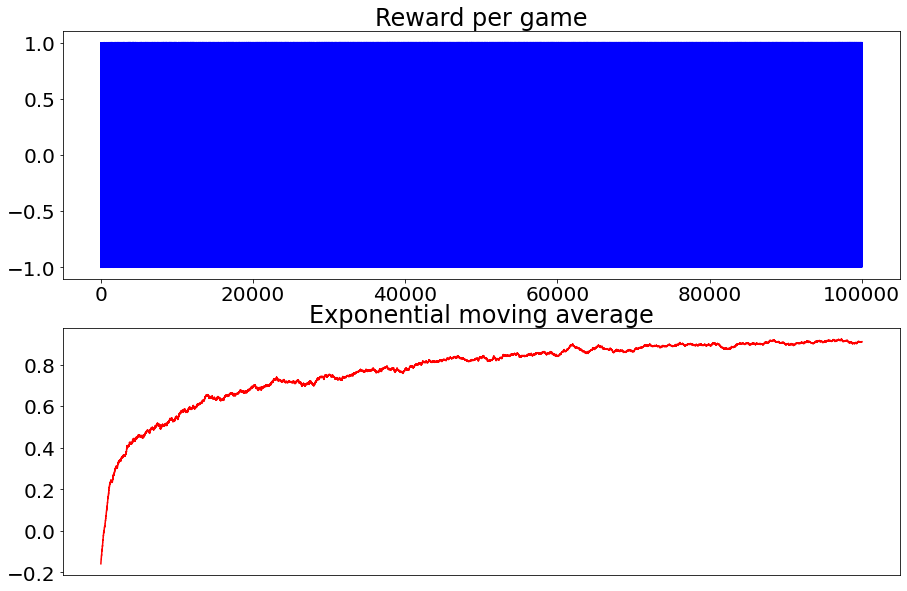

In [ ]:
# Plot: Reward per game
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(2,figsize=(15,10))

axs[0].plot(np.arange(0,N_episodes), R_save, 'b')
axs[1].plot(np.arange(0,N_episodes-1999), moving_average(R_save, n=2000), 'r')
axs[0].set_title("Reward per game")
axs[1].set_title("Exponential moving average")
plt.xticks([])

Text(0.5, 0, 'Number of games')

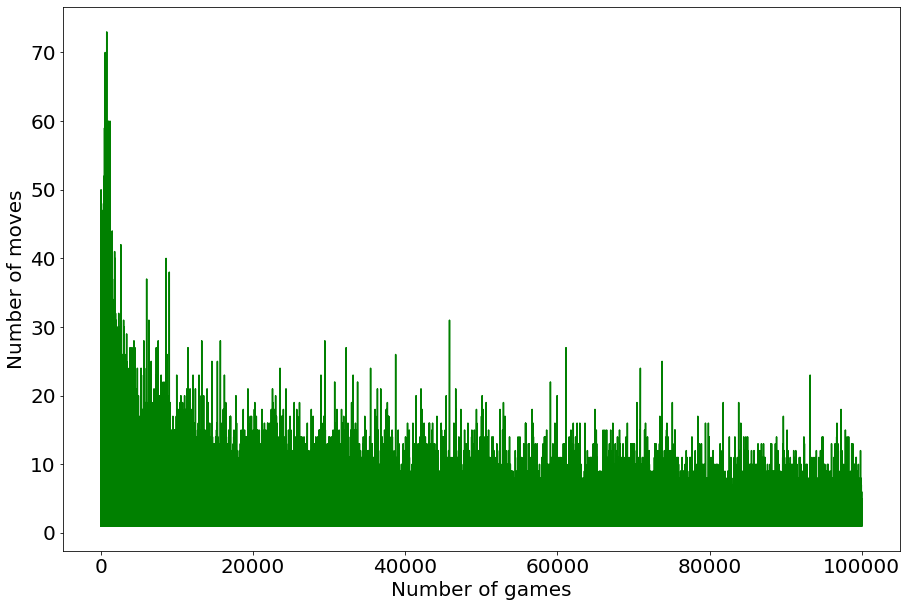

In [ ]:
# Plot: Number of moves per game vs training time
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(np.arange(0,N_episodes), N_moves_save, 'g')
plt.ylabel('Number of moves')
plt.xlabel('Number of games')


Q-Learning is an example of model-free learning algorithm. It does not assume that agent knows anything about the state-transition and reward models. However, the agent will discover what are the good and bad actions by trial and error.
The basic idea of Q-Learning is to approximate the state-action pairs Q-function from the samples of Q(s, a) that we observe during interaction with the enviornment. This approach is known as Time-Difference Learning.